## Communication neuroscience on a shoestring

### Compliance Analysis

This script performs preprocessing steps as in the first notebook, but separates the data out according to sessions (1 and 2) and compliance-gaining condition (experimental group: 'request' vs. control group: 'control').

#### Import modules

In [1]:
import os, pickle, warnings, scipy.stats, mne, collections
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from utils import utils
from autoreject import get_rejection_threshold, AutoReject, compute_thresholds 

#### Load data into MNE objects

In [ ]:
subjects             = list(np.load('../data/subjects.npy', allow_pickle=True))
compliance_condition = list(np.load('../data/compliance_condition.npy', allow_pickle=True))

sessions_to_import   = [1, 2]
results_drop_run     = []

for current_session in sessions_to_import:
    print('Current Session')
    print(current_session)
    print('--------------')

    stats_data = np.zeros(4)

    all_evokeds = []
    trials_res = []

    for curr_subject in subjects[:]:
        print("Current Subject #" + str(curr_subject))
        
        raw = utils.load_data('../data/Study_AB/', 
                              subject_nb = curr_subject, sfreq = 256., 
                              session_nb = current_session);

        raw.filter(0.1, 20, method='iir', verbose= False);

        events = mne.find_events(raw, min_duration=0, shortest_event = 0);
        event_id = {'Positive': 1, 'Neutral': 2};

        # Creating an Epoch object with standard parameters 
        epochs = mne.Epochs(raw, events = events, 
                        event_id = event_id, 
                        tmin = -0.1, tmax = 0.8, baseline = (-0.1,0),
                        detrend = 1, preload = True, verbose = False,
                        #picks=[0,3]
                           ); 

        #Getting the automated rejection threshold for this file - otherwise same parameters as above
        print('------------ Autoreject: Get Threshold ------------')
        reject = get_rejection_threshold(epochs, decim=2)

        epochs = mne.Epochs(raw, events=events, 
                        event_id=event_id, 
                        tmin = -0.1, tmax = 0.8, baseline = (None, 0),
                        reject = reject, detrend = 1,preload=True,verbose=False,
                        #picks=[0,3]
                           );

        epochs.drop_bad(reject=reject)

        ar = AutoReject( n_interpolate= [0], cv=5, random_state=42, n_jobs=1, verbose=False );
        epochs_ar, reject_log = ar.fit_transform(epochs, return_log=True)
        stats_data[1] = np.round(epochs_ar['Neutral'].get_data().shape[0])
        stats_data[2] = np.round(epochs_ar['Positive'].get_data().shape[0])

        epochs_ar.drop_bad()
        sample_drop = (1 - len(epochs_ar.events)/len(events)) * 100
        stats_data[3] = sample_drop
        trials_res.append(stats_data.copy())

    results_drop_run.append(np.asarray(trials_res)[:,3])

Current Session
1
--------------
Current Subject #A-3
Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ...   119.387 secs
Ready.
107 events found
Event IDs: [1 2]
------------ Autoreject: Get Threshold ------------
Estimating rejection dictionary for eeg


In [13]:
drop_rate_df              = pd.DataFrame(np.asarray(results_drop_run).T, columns = ['session1', 'session2'], index = subjects)
drop_rate_df['condition'] = compliance_condition
drop_rate_df.to_csv('../data/ap20.csv')
drop_rate_df.head()

,session1,session2,condition
A-3,60.747664,80.373832,control
A-5,79.047619,88.679245,control
A-6,83.177570,49.532710,request
A-7,64.150943,42.452830,control
A-8,40.000000,42.990654,request


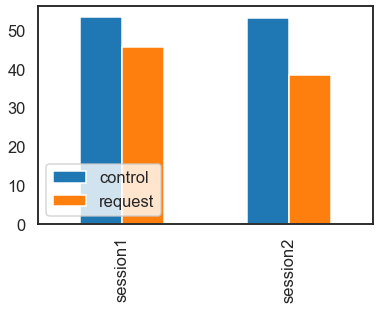

In [4]:
df = drop_rate_df.groupby(['condition']).mean().T
ax = df.plot(kind='bar');
ax.legend(loc='lower left', frameon=True);

In [5]:
drop_rate_df

,session1,session2,condition
A-3,60.747664,82.242991,control
A-5,80.952381,85.849057,control
A-6,71.962617,42.056075,request
A-7,61.320755,26.415094,control
A-8,40.952381,64.485981,request
A-9,45.283019,61.682243,control
A-12,20.754717,45.794393,request
A-14,42.056075,22.641509,request
A-15,36.111111,57.547170,control
A-17,64.150943,69.158879,control


In [6]:
drop_rate_df.groupby(['condition']).mean()

,session1,session2
condition,,
control,53.401866,53.178284
request,45.563301,38.397020


In [7]:
drop_rate_df.groupby(['condition']).std()

,session1,session2
condition,,
control,15.168037,19.317472
request,21.526946,18.254236


In [8]:
scipy.stats.ttest_ind( drop_rate_df['session1'][drop_rate_df['condition']=='control'],
                       drop_rate_df['session1'][drop_rate_df['condition']=='request'])

Ttest_indResult(statistic=1.4372687130581987, pvalue=0.15755905755985733)

In [9]:
scipy.stats.ttest_ind( drop_rate_df['session2'][drop_rate_df['condition']=='control'],
                       drop_rate_df['session2'][drop_rate_df['condition']=='request'])

Ttest_indResult(statistic=2.6971211869472307, pvalue=0.009807782596793572)

In [10]:
scipy.stats.ttest_rel( drop_rate_df['session1'][drop_rate_df['condition']=='control'],
                       drop_rate_df['session2'][drop_rate_df['condition']=='control'])

Ttest_relResult(statistic=0.059883191771406406, pvalue=0.952789320419277)

In [11]:
scipy.stats.ttest_rel( drop_rate_df['session1'][drop_rate_df['condition']=='request'],
                       drop_rate_df['session2'][drop_rate_df['condition']=='request'])

Ttest_relResult(statistic=1.402782598280692, pvalue=0.17403684120657636)